# Chapter 27: Mediation Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from joblib import Parallel, delayed

np.random.seed(42)

%load_ext watermark
%watermark --iversions

statsmodels      : 0.14.0
pandas           : 2.0.3
matplotlib       : 3.7.2
numpy            : 1.24.3
matplotlib_inline: 0.1.6



In [2]:
def BKmediation(Z, M, Y, X):
    # mediator reg
    medreg = sm.OLS(M, np.c_[sm.add_constant(Z), X]).fit(vcov_type="HC1")
    medZcoef, medZse = medreg.params[1], medreg.bse[1]
    outreg = sm.OLS(Y, np.c_[sm.add_constant(Z), M, X]).fit(vcov_type="HC1")
    outZcoef, outZse = outreg.params[1], outreg.bse[1]
    outMcoef, outMse = outreg.params[2], outreg.bse[2]
    NDE, NIE = outZcoef, outMcoef * medZcoef
    # sobel's variance
    NDEse = outZse
    NIEse = np.sqrt(outMse**2 * medZcoef**2 + medZse**2 * outMcoef**2)
    return np.array([NDE, NDEse, NDE / NDEse, NIE, NIEse, NIE / NIEse])

In [3]:
def simulation(beta1, theta2, theta1):
    n = 200
    Z = np.random.binomial(1, 0.5, n)
    X = np.random.normal(size=n)
    M = beta1 * Z + X + np.random.normal(size=n)
    Y = theta1 * Z + theta2 * M + X + np.random.normal(size=n)
    return BKmediation(Z, M, Y, X)

$\beta_1 = \theta_2 = \theta_1 = 1$

0.16168798729204314 0.1592993872148648
0.15508938768915878 0.1594246671589853


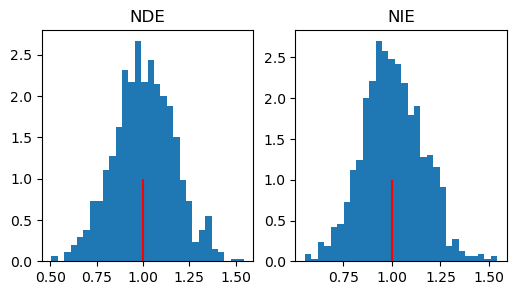

In [4]:
res = Parallel(n_jobs=-1)(delayed(simulation)(1, 1, 1) for _ in range(1000))
res = np.vstack(res)
print(res[:, 0].std(), res[:, 1].mean())
print(res[:, 3].std(), res[:, 4].mean())

f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].hist(res[:, 0], bins=30, density=True)
ax[0].vlines(1, 0, 1, color="red")
ax[0].set_title("NDE")
ax[1].hist(res[:, 3], bins=30, density=True)
ax[1].vlines(
    1,
    0,
    1,
    color="red",
)
ax[1].set_title("NIE")
plt.show()

$\theta_2$ = 0

0.16070039875959033 0.15894602890501858
0.07139184520607268 0.07184486066517198


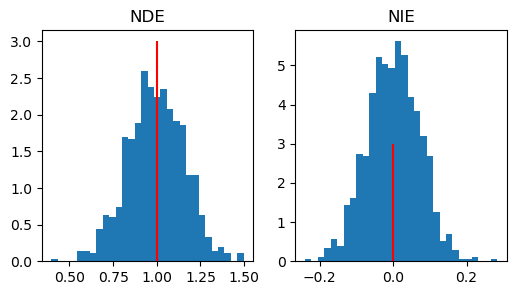

In [5]:
res = Parallel(n_jobs=-1)(delayed(simulation)(1, 0, 1) for _ in range(1000))
res = np.vstack(res)
print(res[:, 0].std(), res[:, 1].mean())
print(res[:, 3].std(), res[:, 4].mean())

f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].hist(res[:, 0], bins=30, density=True)
ax[0].vlines(1, 0, 3, color="red")
ax[0].set_title("NDE")
ax[1].hist(res[:, 3], bins=30, density=True)
ax[1].vlines(
    0,
    0,
    3,
    color="red",
)
ax[1].set_title("NIE")
plt.show()

$\beta_1 = 0$

0.13398443810512395 0.1421209837224335
0.010519116540859337 0.012717706993520813


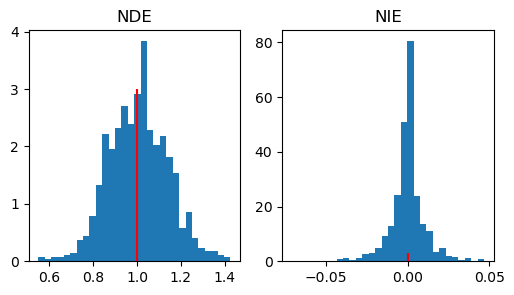

In [6]:
res = Parallel(n_jobs=-1)(delayed(simulation)(0, 0, 1) for _ in range(1000))
res = np.vstack(res)
print(res[:, 0].std(), res[:, 1].mean())
print(res[:, 3].std(), res[:, 4].mean())

f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].hist(res[:, 0], bins=30, density=True)
ax[0].vlines(1, 0, 3, color="red")
ax[0].set_title("NDE")
ax[1].hist(res[:, 3], bins=30, density=True)
ax[1].vlines(
    0,
    0,
    3,
    color="red",
)
ax[1].set_title("NIE")
plt.show()

In [9]:
import formulaic as fm

jobsdata = pd.read_csv("jobsdata.csv")
X = (
    fm.Formula(
        """
                ~ econ_hard + depress1 + sex + age + occp + marital +
                nonwhite + educ + income -1
                """
    )
    .get_model_matrix(data=jobsdata)
    .values
)
Z, M, Y = jobsdata[["treat", "job_seek", "depress2"]].values.T

In [22]:
res = BKmediation(Z, M, Y, X)
pd.DataFrame([res[0:3], res[3:6]], index=["NDE", "NIE"], columns=["coef", "se", "t"])

,coef,se,t
NDE,-0.036789,0.040794,-0.901813
NIE,-0.013733,0.009008,-1.524646
